# Introduction

We will work with MiloR in this example notebook.

In [33]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import scipy


# Milo

Milo is a statistical method to quantify changes in cellular abundancies in neighborhoods of cells in high-dimensional space. Given a data with cells from two conditions, Milo partitions the cell phenotype space in a set of (possibly overlapping) neighborhoods and allows quantification of differential abundances of cells from one condition compared to another in each neighborhood. It outputs associated logfoldchange between the two conditions, p-values and multiple comparisons adjusted p-values for each neighborhood. Furthermore, Milo allows one to annotate each neighborhood as a distinct celltype based on the proportion of cells from each celltype in the neighborhood. All of this is discussed in the code below. 

Milo's strength lies in detecting subtle `local` changes in cellular abundances. This is possible by the use of graphs and looking for changes in occupancy locally along the graph. 

For more details, please see the original publication: https://www.nature.com/articles/s41587-021-01033-z.

There is a Python version of Milo, but it is still under development so we will call the R implementation from Python.

In [34]:
from sklearn.decomposition import PCA
from MulticoreTSNE import MulticoreTSNE as TSNE

In [35]:
outbase = '/home/clinic/Documents/mskcc/'

In [36]:
from matplotlib.cm import get_cmap
cols_use = get_cmap('tab20').colors

## Load example data

As an example data, we will consider cells from a mouse lung tumor model where we were interested in effect of loss of T-regs on the tumor microenvironment. So control is cells from the tumor environment (`CTRL`) and the treatment is cells from the microenvironment under T-reg depletion (`DT`). 

Here, we will consider the myeloid cells under control and treatment. Our goal will be to use Milo to identify regions of cellular phenotype space that have a differential occupancy of cells from different conditions. 

In [37]:
adata = sc.read_h5ad('/home/clinic/Documents/mskcc/clean_myeloid.h5ad')
cell_factor_matrix = np.array(pd.read_csv('/home/clinic/Documents/mskcc/milo_cell_scores.csv', header=None, index_col=False))

In [38]:
adata

AnnData object with n_obs × n_vars = 4718 × 12786
    obs: 'Clusters', 'Celltype', 'SampleID', 'name', 'background', 'condition', 'replicate', 'experiment', 'ncells', 'libsize', 'mito_fraction', 'ribo_fraction', 'mhc_fraction', 'actin_fraction', 'cytoskeleton_fraction', 'malat1_fraction', 'scrublet_predict', 'scrublet_score', 'lowlibsize', 'Clusters_myeloid', 'Celltype_myeloid'
    obsm: 'X_pca', 'X_tsne', 'imputed_data'
    layers: 'norm_count', 'norm_log'

In [39]:
# convert the clusters to categorical for effective plotting using Scanpy's plot command
adata.obs['Clusters_myeloid_cat'] = pd.Categorical(adata.obs['Clusters_myeloid'])

/home/clinic/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/clinic/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/clinic/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


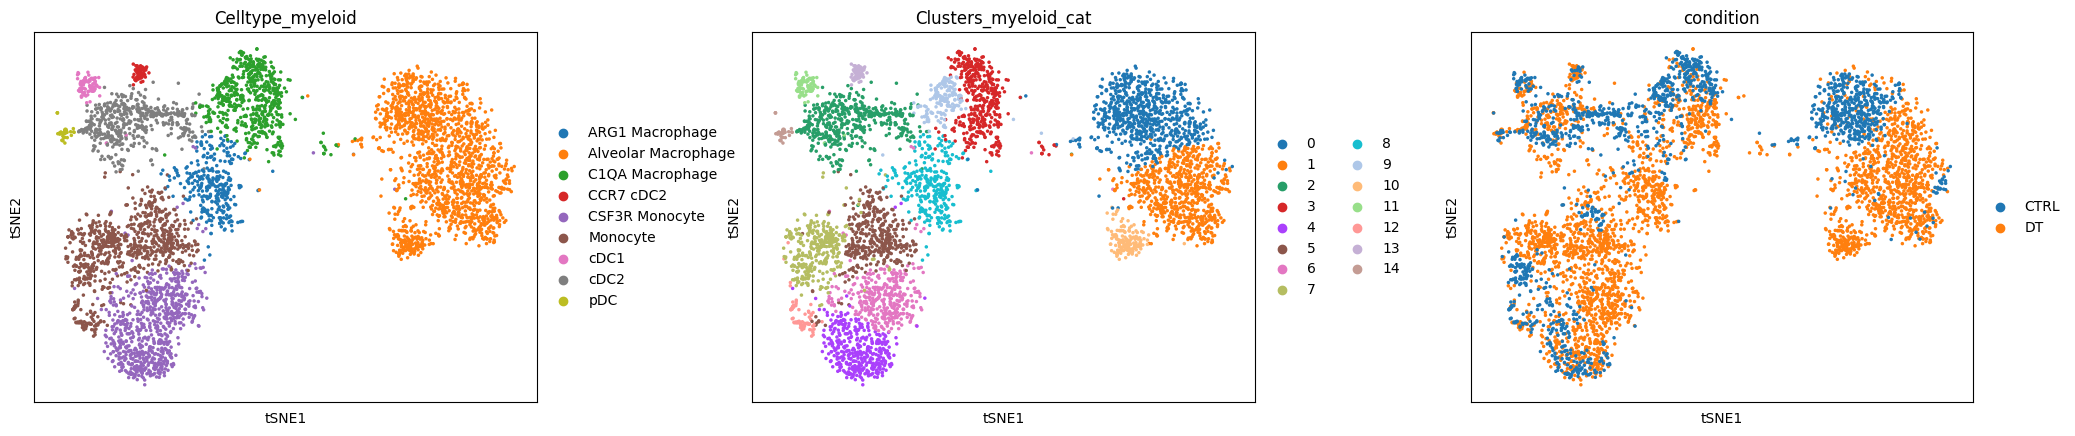

In [40]:
sc.pl.tsne(adata, color = ['Celltype_myeloid', 'Clusters_myeloid_cat', 'condition'], wspace = 0.3)

## Alternate visual

In [41]:
df_temp = pd.DataFrame({'tsne_x': adata.obsm['X_tsne'][:, 0], 'tsne_y': adata.obsm['X_tsne'][:, 1], 
                        'condition': adata.obs['condition']}, index = adata.obs.index)

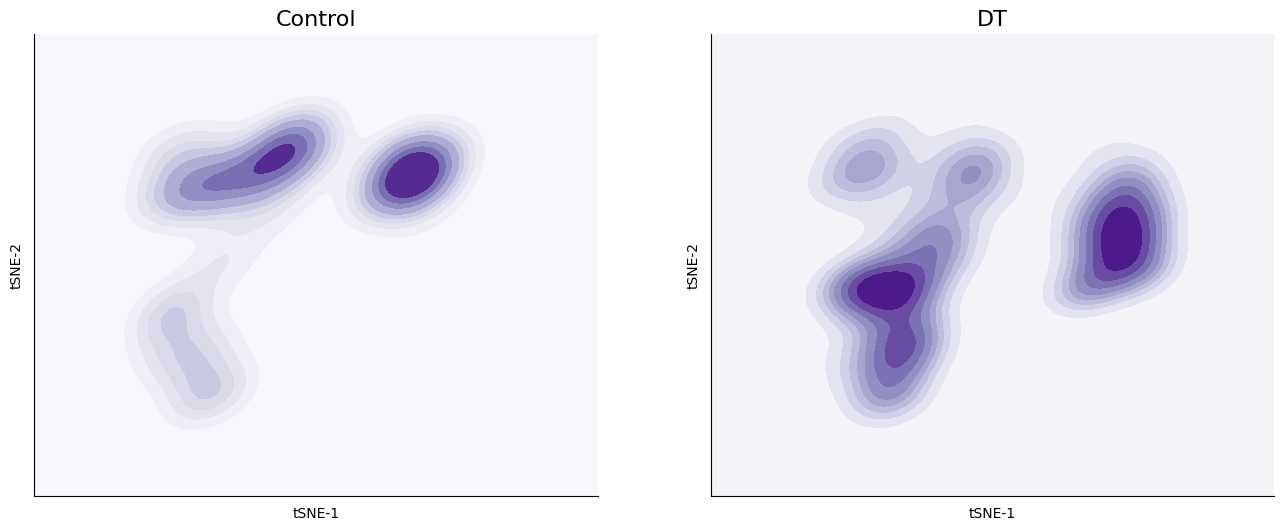

In [42]:
import seaborn as sns
fig = plt.figure(figsize = (8*2, 6))
ax = fig.add_subplot(1, 2, 1)
sns.scatterplot(data = df_temp, x = 'tsne_x', y = 'tsne_y', s = 1, ax = ax)
sns.kdeplot(data=df_temp[df_temp['condition'] == 'CTRL'], x="tsne_x", y="tsne_y",
    fill=True, thresh=0, levels=10, cmap="Purples", ax = ax, cut = 4)
ax.set_xticks([]);
ax.set_yticks([]);
ax.set_title('Control', fontsize = 16)
ax.set_xlabel('tSNE-1')
ax.set_ylabel('tSNE-2')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax = fig.add_subplot(1, 2, 2)
sns.scatterplot(data = df_temp, x = 'tsne_x', y = 'tsne_y', s = 0, ax = ax)
sns.kdeplot(data=df_temp[df_temp['condition'] == 'DT'], x="tsne_x", y="tsne_y",
    fill=True, thresh=0, levels=10, cmap="Purples", ax = ax, cut = 4)
ax.set_xticks([]);
ax.set_yticks([]);
ax.set_title('DT', fontsize = 16)
ax.set_xlabel('tSNE-1')
ax.set_ylabel('tSNE-2')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#fig.savefig(outbase + 'Ctrl_DT_kdeplot_endo.png', dpi = 150, bbox_inches = 'tight')

## Set up for MiloR

We will now call Milo from Python using rpy2 and anndata2ri. So, load the appropriate packages and provide path to R_HOME and R_USER.

In [43]:
import rpy2
import anndata2ri
import os


# anndata2ri interconverts AnnData and Single Cell Experiment objects
anndata2ri.activate()
%load_ext rpy2.ipython
#%reload_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [44]:
adata

AnnData object with n_obs × n_vars = 4718 × 12786
    obs: 'Clusters', 'Celltype', 'SampleID', 'name', 'background', 'condition', 'replicate', 'experiment', 'ncells', 'libsize', 'mito_fraction', 'ribo_fraction', 'mhc_fraction', 'actin_fraction', 'cytoskeleton_fraction', 'malat1_fraction', 'scrublet_predict', 'scrublet_score', 'lowlibsize', 'Clusters_myeloid', 'Celltype_myeloid', 'Clusters_myeloid_cat'
    uns: 'Celltype_myeloid_colors', 'Clusters_myeloid_cat_colors', 'condition_colors'
    obsm: 'X_pca', 'X_tsne', 'imputed_data'
    layers: 'norm_count', 'norm_log'

## Object for milo

Create a separate anndata object for Milo for simplicity. We will need to provide log-normalized data, the condition, celltypes information. We also need to provide the computed PCA coordinates to construct the graph and tSNE coordinates to visualize.

In [45]:
adata_milo = sc.AnnData(adata.layers['norm_log'].copy(), 
                        obs = adata.obs[['SampleID', 'Celltype_myeloid', 'condition']], 
                        var = adata.var)
adata_milo.obsm['X_pca'] = cell_factor_matrix
adata_milo.obsm['X_tsne'] = adata.obsm['X_tsne']
adata_milo.obsm_keys

/tmp/ipykernel_3447/2123230209.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_milo = sc.AnnData(adata.layers['norm_log'].copy(),


<bound method AnnData.obsm_keys of AnnData object with n_obs × n_vars = 4718 × 12786
    obs: 'SampleID', 'Celltype_myeloid', 'condition'
    obsm: 'X_pca', 'X_tsne'>

## Set up in R

In [46]:
%%R

library(miloR)
library(igraph)

R[write to console]: Loading required package: edgeR

R[write to console]: Loading required package: limma

R[write to console]: 
Attaching package: ‘igraph’


R[write to console]: The following object is masked from ‘package:miloR’:

    graph


R[write to console]: The following objects are masked from ‘package:stats’:

    decompose, spectrum


R[write to console]: The following object is masked from ‘package:base’:

    union




We can directly input anndata object to R since we have loaded the anndata2ri packages. This will convert the anndata object into SingleCellExperiment object (for more details see here: https://bioconductor.org/packages/release/bioc/html/SingleCellExperiment.html).

In [47]:
%%R -i adata_milo
adata_milo

/home/clinic/.local/lib/python3.10/site-packages/anndata2ri/r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)


class: SingleCellExperiment 
dim: 12786 4718 
metadata(0):
assays(1): X
rownames(12786): GNAI3 CDC45 ... MIR155HG IGHV5-9
rowData names(0):
colnames(4718): 120703424032052000 120703436053422000 ...
  232261695269612011 239407446735798011
colData names(3): SampleID Celltype_myeloid condition
reducedDimNames(2): PCA TSNE
mainExpName: NULL
altExpNames(0):


Convert to a Milo object:

In [50]:
%%R 
myeloid_milo <- Milo(adata_milo)
myeloid_milo

class: Milo 
dim: 12786 4718 
metadata(0):
assays(1): X
rownames(12786): GNAI3 CDC45 ... MIR155HG IGHV5-9
rowData names(0):
colnames(4718): 120703424032052000 120703436053422000 ...
  232261695269612011 239407446735798011
colData names(3): SampleID Celltype_myeloid condition
reducedDimNames(2): PCA TSNE
mainExpName: NULL
altExpNames(0):
nhoods dimensions(2): 1 1
nhoodCounts dimensions(2): 1 1
nhoodDistances dimension(1): 0
graph names(0):
nhoodIndex names(1): 0
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(0):
nhoodAdjacency dimension(2): 1 1


Build a graph in the Milo framework:

In [51]:
%%R 
myeloid_milo <- buildGraph(myeloid_milo, k=30, d=50, reduced.dim = "PCA")

R[write to console]: Constructing kNN graph with k:30



## Design Matrix

Now we set up the Design matrix. We follow the same procedure as illustrated in the Milo package example documentation (https://rawcdn.githack.com/MarioniLab/miloR/3646391023f600bae00efd9d940b888503d7a536/docs/articles/milo_demo.html). The example in this notebook does not have many covariates, so this is an example of vanilla application of Milo. For more complicated scenarios, please see https://bioconductor.org/packages/release/bioc/vignettes/miloR/inst/doc/milo_contrasts.html.

In [52]:
design_df = adata_milo.obs[["condition", "SampleID"]].copy()
design_df.drop_duplicates(inplace=True)
design_df.index = design_df['SampleID']
design_df

,condition,SampleID
SampleID,,
2_DT_1_CD45_minus,DT,2_DT_1_CD45_minus
2_DT_1_CD45plus,DT,2_DT_1_CD45plus
2_DT_2_CD45minus,DT,2_DT_2_CD45minus
2_DT_2_CD45plus,DT,2_DT_2_CD45plus
2_DT_3_CD45_minus,DT,2_DT_3_CD45_minus
2_DT_3_CD45plus,DT,2_DT_3_CD45plus
2_ctl_1_CD45minus,CTRL,2_ctl_1_CD45minus
2_ctl_1_CD45plus,CTRL,2_ctl_1_CD45plus
2_ctl_2_CD45plus,CTRL,2_ctl_2_CD45plus


## Differential analysis 

Now we perform differential abundance analysis. Note on the parameters used for making neighborhoods:

`prop = 0.1`: It is the proportion of the data to randomly sample as the initial "anchor" cells. The larger the value of prop, the more the number of neighborhoods. 

`k = 30`: This is the number of nearest neighbors in the initial graph.

`d = 50`: This represents the number of principal components to use (Note: we already computed PCA and hence specify `reduced_dims = "PCA"`)

`refined = TRUE`: Implements a refined sampling schemes. 

For more details please see: https://rdrr.io/github/MarioniLab/miloR/man/makeNhoods.html

In [53]:
%%R -i design_df -o DA_results_myeloid
## Define neighbourhoods
myeloid_milo <- makeNhoods(myeloid_milo, prop = 0.1, k = 30, d=50, refined = TRUE, reduced_dims = "PCA")

## Count cells in neighbourhoods
myeloid_milo <- countCells(myeloid_milo, meta.data = data.frame(colData(myeloid_milo)), sample="SampleID")

## Calculate distances between cells in neighbourhoods
## for spatial FDR correction
myeloid_milo <- calcNhoodDistance(myeloid_milo, d=50, reduced.dim = "PCA")

## Test for differential abundance
DA_results_myeloid <- testNhoods(myeloid_milo, design = ~condition, design.df = design_df)

R[write to console]: Checking valid object

R[write to console]: Checking meta.data validity

R[write to console]: Counting cells in neighbourhoods

R[write to console]: Using TMM normalisation

R[write to console]: Performing spatial FDR correction withk-distance weighting



In [54]:
DA_results_myeloid.head()

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR
1,3.723320,12.448321,10.752843,0.001052,0.004362,1.0,0.005392
2,0.797075,12.717086,0.893756,0.344528,0.463886,2.0,0.496013
3,-0.247363,12.877909,0.085857,0.769530,0.840088,3.0,0.862595
4,-1.622112,13.202110,3.715533,0.053991,0.100836,4.0,0.113803
5,2.761308,12.864131,7.502986,0.006192,0.017474,5.0,0.020219


Text(0, 0.5, '- log10(Spatial FDR)')

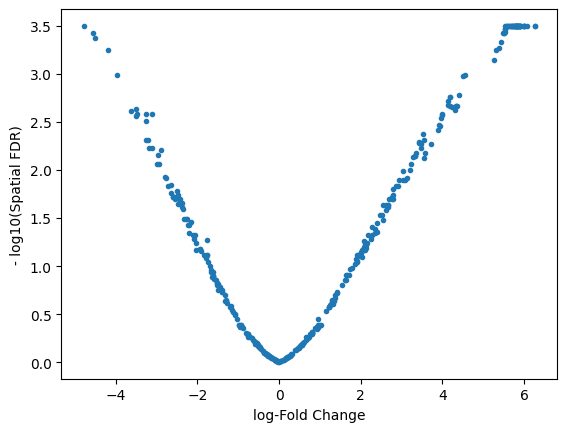

In [56]:
plt.plot(DA_results_myeloid.logFC, -np.log10(DA_results_myeloid.SpatialFDR), '.');
plt.xlabel("log-Fold Change");
plt.ylabel("- log10(Spatial FDR)")

## Visualize in R

Build the fancy graph visual:

In [57]:
%%R
myeloid_milo <- buildNhoodGraph(myeloid_milo)

In [58]:
%%R 
head(DA_results_myeloid)

       logFC   logCPM          F      PValue         FDR Nhood  SpatialFDR
1  3.7233196 12.44832 10.7528427 0.001051591 0.004362292     1 0.005391649
2  0.7970752 12.71709  0.8937561 0.344528075 0.463885882     2 0.496013078
3 -0.2473627 12.87791  0.0858567 0.769529842 0.840088452     3 0.862595019
4 -1.6221123 13.20211  3.7155327 0.053990923 0.100835989     4 0.113802685
5  2.7613083 12.86413  7.5029855 0.006191534 0.017473885     5 0.020218778
6 -0.4004948 12.86356  0.2174719 0.641002586 0.737830771     6 0.768120684


Please refer to the documentation for plotNhoodGraphDA for the choice of parameters: https://rdrr.io/github/MarioniLab/miloR/man/plotNhoodGraphDA.html.

In the example below:
(1) We visualize the NhoodGraph for endomilo

(2) Color the neighborhood by 'SpatialFDR' as specified in res_column (which will be picked up from the DA_results_endo dataframe)

(3) alpha = alpha_val is a parameter that only includes those neighborhood that have SpatialFDR (res_column) smaller than alpha_val. For below, we set it to 1, so we can look at all neighborhoods. You may want to choose a different parameter if you want to focus on only those neighborhoods that are significantly differential. 

(4) layout = "TSNE" specifies thw low-dimensional visual to use. 

For aesthetics:

(5) size_range specifices the range of sizes of the circles for the neighborhoods. 

(6) node_stroke specifies the thickness of connecting lines.

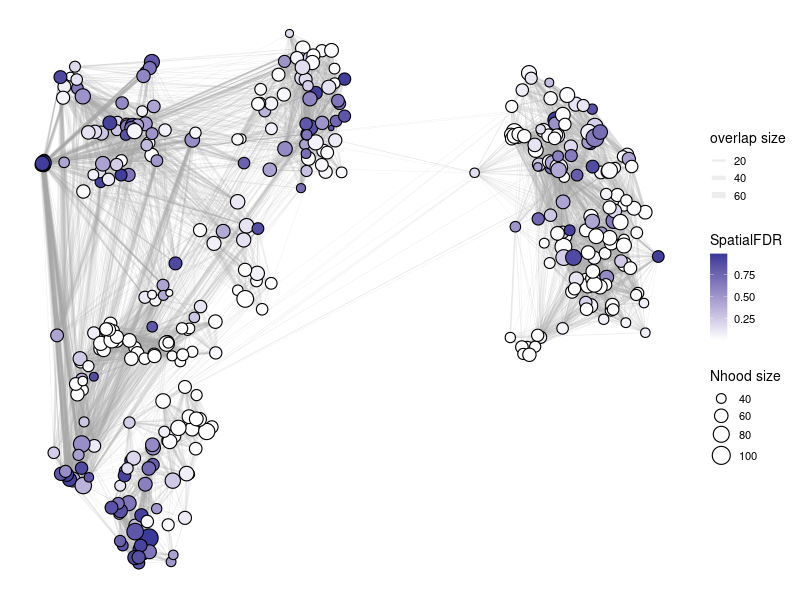

In [59]:
%%R -w 800 -h 600
alpha_val = 1
library(ggplot2)
p1 <- plotNhoodGraphDA(myeloid_milo, DA_results_myeloid, res_column = 'SpatialFDR', alpha=alpha_val, 
                 layout="TSNE", size_range = c(2, 8), node_stroke =0.8)
p1

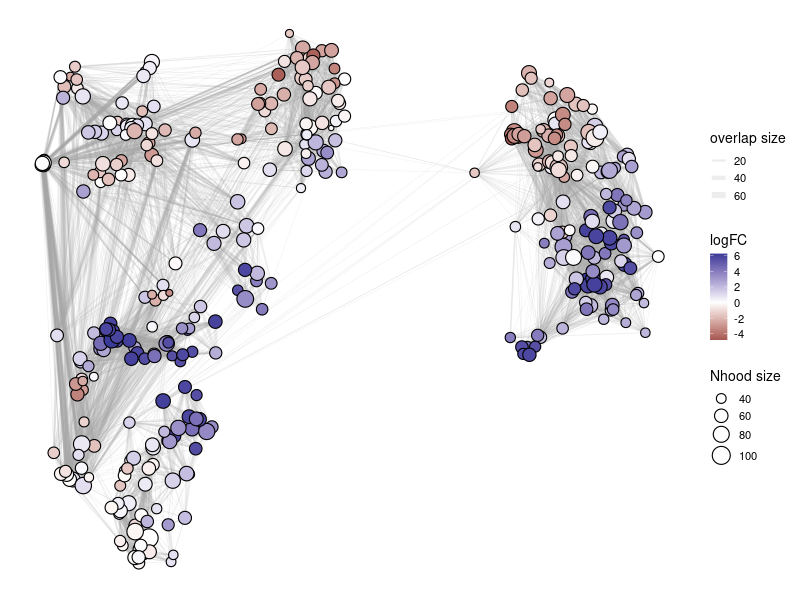

In [60]:
%%R -w 800 -h 600
alpha_val = 1
library(ggplot2)
p1 <- plotNhoodGraphDA(myeloid_milo, DA_results_myeloid, res_column = 'logFC', alpha=alpha_val, 
                 layout="TSNE", size_range = c(2, 8), node_stroke =0.8)
p1

Plot and save directly from R:

In [61]:
%%R -w 600 -h 450
library(ggplot2)
alpha_val = 1
outbase = '/home/clinic/Documents/mskcc/spectra-gpu/milo-work/figures/'
for (j in c('SpatialFDR', 'FDR', 'PValue', 'logFC')){
    p1 <- plotNhoodGraphDA(myeloid_milo, DA_results_myeloid, res_column = j, alpha=alpha_val, layout="TSNE", 
                           size_range = c(2, 8), node_stroke =.8)
    p1    
    ggsave(paste0(outbase, 'milor_R_myeloid_', j, '.pdf'), p1, dpi = 200)
}

Saving 8.33 x 6.25 in image
Saving 8.33 x 6.25 in image
Saving 8.33 x 6.25 in image
Saving 8.33 x 6.25 in image


## Add celltype info

Milo also allows to divide the neighborhoods based on the most representative celltype in that neighborhood. 

In [62]:
%%R 
DA_results_myeloid <- annotateNhoods(myeloid_milo, DA_results_myeloid, coldata_col = "Celltype_myeloid")
head(DA_results_myeloid)

       logFC   logCPM          F      PValue         FDR Nhood  SpatialFDR
1  3.7233196 12.44832 10.7528427 0.001051591 0.004362292     1 0.005391649
2  0.7970752 12.71709  0.8937561 0.344528075 0.463885882     2 0.496013078
3 -0.2473627 12.87791  0.0858567 0.769529842 0.840088452     3 0.862595019
4 -1.6221123 13.20211  3.7155327 0.053990923 0.100835989     4 0.113802685
5  2.7613083 12.86413  7.5029855 0.006191534 0.017473885     5 0.020218778
6 -0.4004948 12.86356  0.2174719 0.641002586 0.737830771     6 0.768120684
     Celltype_myeloid Celltype_myeloid_fraction
1 Alveolar Macrophage                         1
2      CSF3R Monocyte                         1
3      CSF3R Monocyte                         1
4 Alveolar Macrophage                         1
5     C1QA Macrophage                         1
6      CSF3R Monocyte                         1


Visualize the cell type fraction distribution for the most representative cell type in each neighborhood:

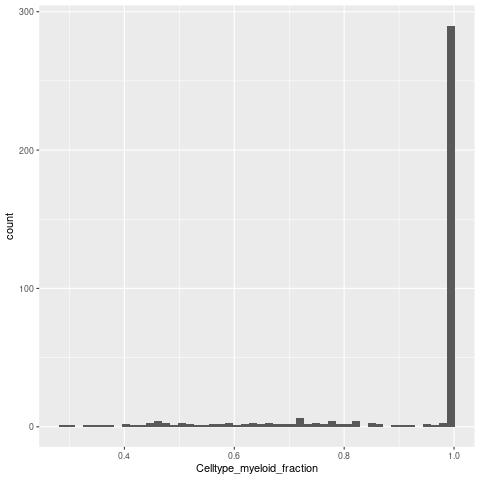

In [63]:
%%R
library(ggplot2)
ggplot(DA_results_myeloid, aes(Celltype_myeloid_fraction)) + geom_histogram(bins=50)


We can relabel the neighborhood as celltype X if 80% of the cells in the neighborhood are of X type, else we can call it "Mixed".

In [64]:
%%R -o DA_results_myeloid
DA_results_myeloid$Myeloid_Celltypes <- ifelse(DA_results_myeloid$Celltype_myeloid_fraction < 0.8, "Mixed", DA_results_myeloid$Celltype_myeloid)
head(DA_results_myeloid)

       logFC   logCPM          F      PValue         FDR Nhood  SpatialFDR
1  3.7233196 12.44832 10.7528427 0.001051591 0.004362292     1 0.005391649
2  0.7970752 12.71709  0.8937561 0.344528075 0.463885882     2 0.496013078
3 -0.2473627 12.87791  0.0858567 0.769529842 0.840088452     3 0.862595019
4 -1.6221123 13.20211  3.7155327 0.053990923 0.100835989     4 0.113802685
5  2.7613083 12.86413  7.5029855 0.006191534 0.017473885     5 0.020218778
6 -0.4004948 12.86356  0.2174719 0.641002586 0.737830771     6 0.768120684
     Celltype_myeloid Celltype_myeloid_fraction   Myeloid_Celltypes
1 Alveolar Macrophage                         1 Alveolar Macrophage
2      CSF3R Monocyte                         1      CSF3R Monocyte
3      CSF3R Monocyte                         1      CSF3R Monocyte
4 Alveolar Macrophage                         1 Alveolar Macrophage
5     C1QA Macrophage                         1     C1QA Macrophage
6      CSF3R Monocyte                         1      CSF3R Monocyte

Make a beeswarm plot to visualize the results. 

Note: The color code in the default version is non-sensical because it is color coded by logFoldChange which is already in the x-axis. Hence there is not colormap to quantify the color code.

R[write to console]: Converting group.by to factor...



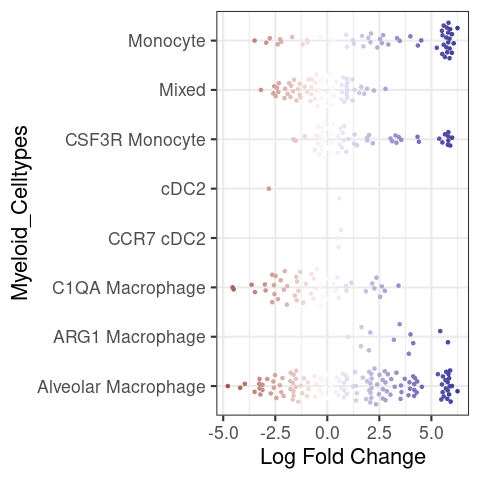

In [65]:
%%R
plotDAbeeswarm(DA_results_myeloid, group.by = "Myeloid_Celltypes", alpha = 1)

R code to change the colormap in the beeswarmplot (again non-sensical because it is quantified in the x-axis):

In [66]:
%%R -w 600 -h 600
library(ggplot2)
library(ggbeeswarm)
library(scales)

p1 <- plotDAbeeswarm(DA_results_myeloid, group.by = "Myeloid_Celltypes", alpha = alpha_val) 

p1 <- p1 + geom_quasirandom(size = 3) 
p1 <- p1 + scale_color_gradient2(low = "navyblue", mid = "gray74", high = "darkred", guide = "colourbar")


outbase = '/home/clinic/Documents/mskcc/spectra-gpu/milo-work/figures/'
ggsave(paste0(outbase, 'milor_R_myeloid_swarmplot.pdf'), p1, dpi = 200)

R[write to console]: Converting group.by to factor...



Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Saving 8.33 x 8.33 in image


## Alternate visual

The following is a python code that loads the `DA_results_myeloid` onto Python and creates a stripplot using Seaborn package. This is a replacement for the beeswarmplot and enables additional control. For example below, we color code each neighborhood by the p-values associated with each neighborhood. So unlike the above beeswarmplot, here the color of the neighborhood is not the `logFoldChange` (which is already on the x-axis):

/tmp/ipykernel_3447/1098034062.py:32: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(scalarmappaple)
/tmp/ipykernel_3447/1098034062.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(cbar.ax.get_yticks(), fontsize = 18)
/tmp/ipykernel_3447/1098034062.py:32: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(scalarmappaple)
/tmp/ipykernel_3447/1098034062.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  c

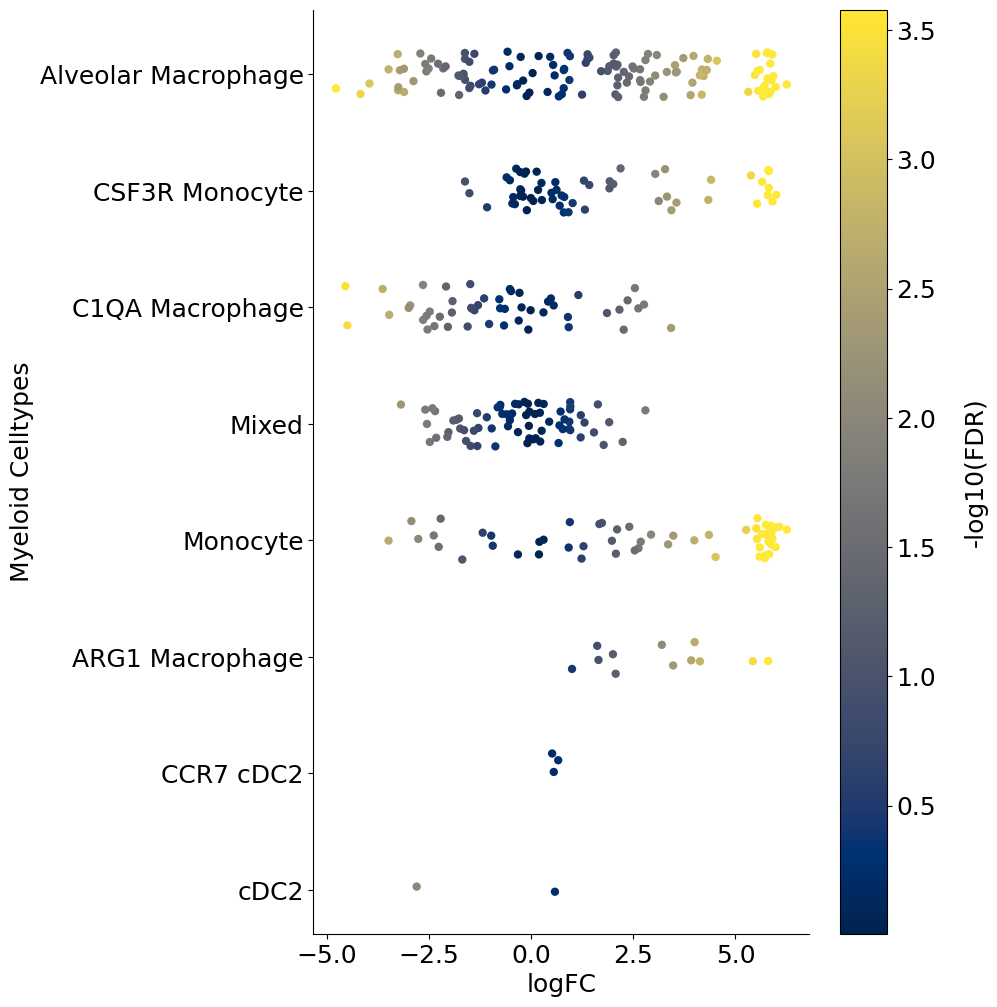

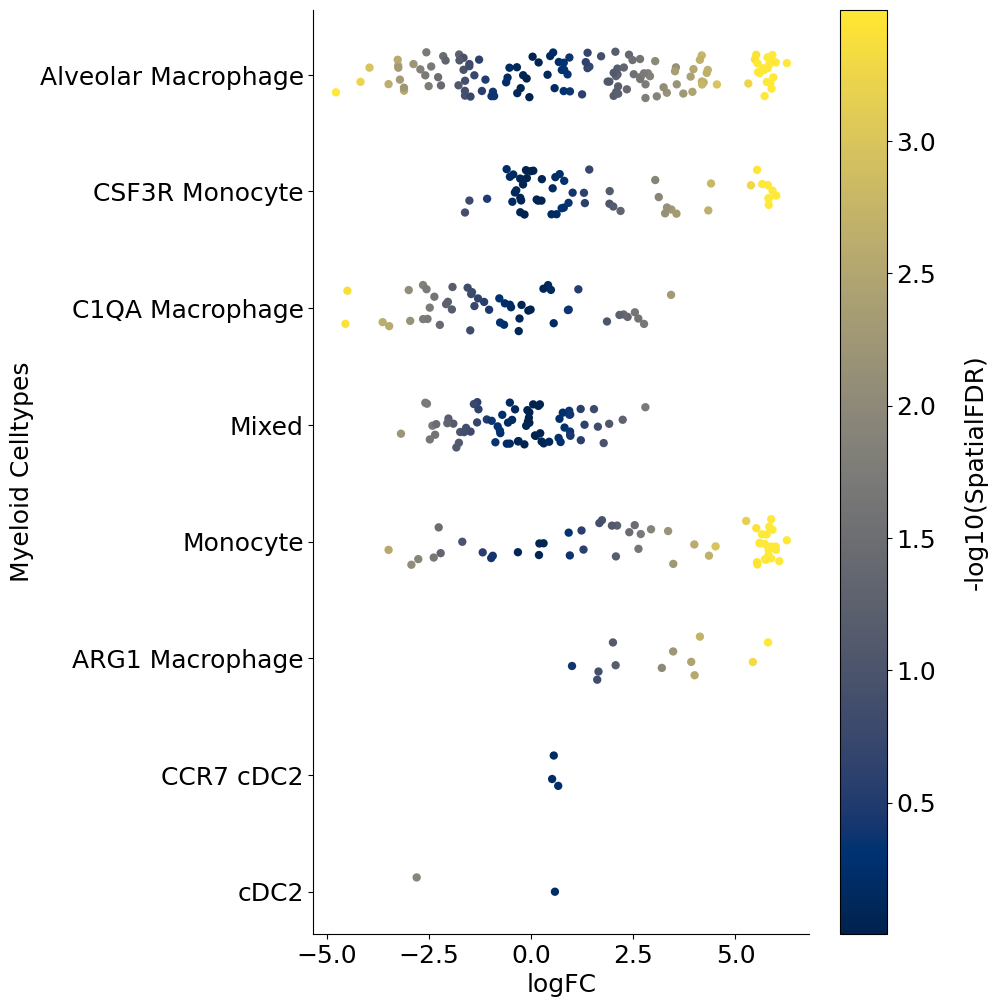

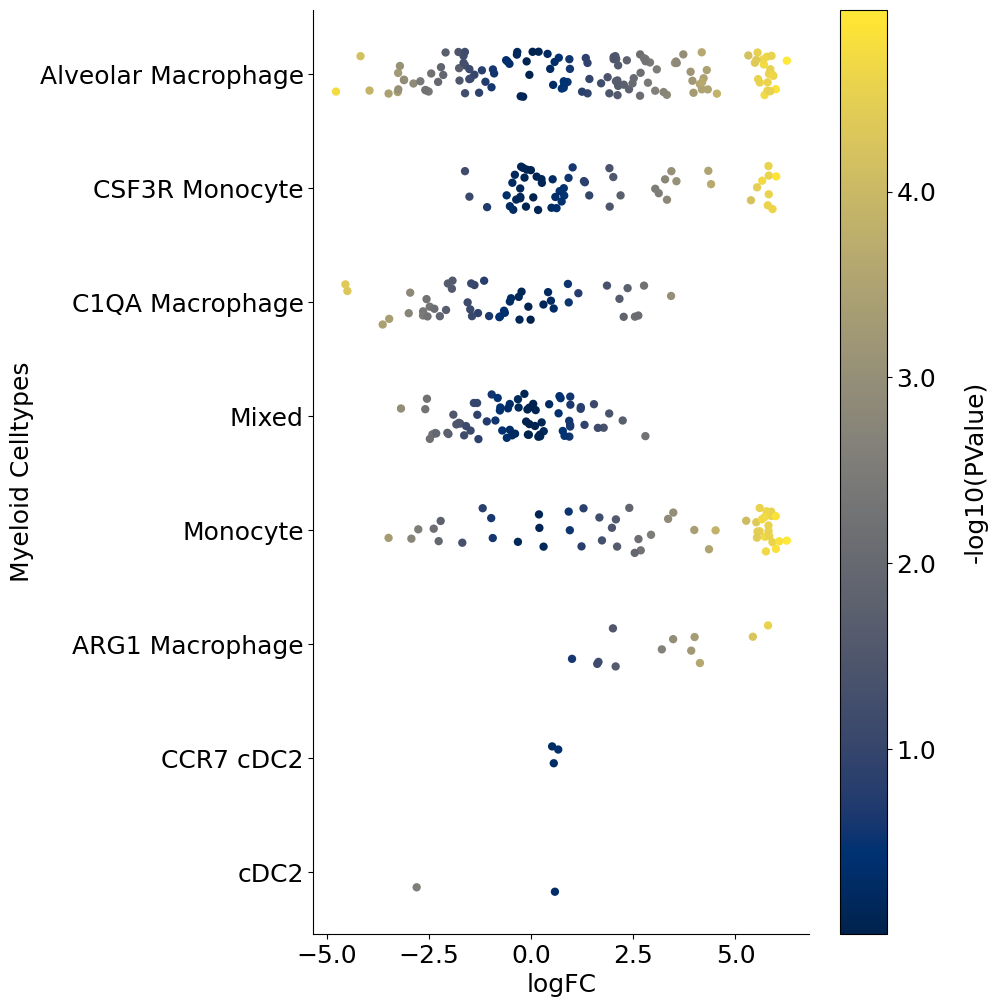

In [67]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

outbase = '/home/clinic/Documents/mskcc/spectra-gpu/milo-work/figures/'

for j, item in enumerate(['FDR', 'SpatialFDR', 'PValue']):
    fig = plt.figure(figsize = (8, 12))
    DA_results_myeloid['log_' + item] = -np.log10(DA_results_myeloid[item])
    ax = fig.add_subplot(1, 1, 1)
    plot = sns.stripplot(x='logFC', y='Myeloid_Celltypes', hue='log_' + item, data=DA_results_myeloid, size = 6, 
              palette='cividis', 
              jitter=0.2, edgecolor='none', ax = ax)
    plot.get_legend().set_visible(False)
    #ax.set_xticklabels(ax.get_xticks(), fontsize = 18)
    #ax.set_yticklabels(ax.get_yticks(), fontsize = 18)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_ylabel('Myeloid Celltypes', fontsize = 18)
    ax.set_xlabel('logFC', fontsize = 18)
    sns.despine()


    # Drawing the side color bar
    normalize = mcolors.Normalize(vmin=DA_results_myeloid['log_' + item].min(), 
                              vmax=DA_results_myeloid['log_' + item].max())
    colormap = cm.cividis

    for n in DA_results_myeloid['log_' + item]:
        plt.plot(color=colormap(normalize(n)))

    scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
    scalarmappaple.set_array(DA_results_myeloid['log_' + item])
    cbar = fig.colorbar(scalarmappaple)
    cbar.ax.set_yticklabels(cbar.ax.get_yticks(), fontsize = 18)
    cbar.ax.set_ylabel('-log10(' + item + ')',  labelpad = 20, rotation=90, fontsize = 18)
    ax.grid(False)
    fig.savefig(outbase + 'milor_myeloid_swarmplot_colored_by_log_' + item + '.pdf', dpi = 300, 
                bbox_inches = 'tight')